# Log Analysis

## Summary
1. Data parsing:
    * parse log lines into different columns with regex `df.select(regexp_extract('column_to_be_parsed', regex_pattern, 1).alias('new_column_name'), ...)`
2. Data cleaning:
    * remove rows with no information `df = df[df['column'].isNotNull()]`
    * fill missing values `df = df.na.fill({'column': 'value'})`
    * deal with date formats, turn '01/Jul/1995:00:00:01 -0400' to '1995-07-01 00:00:01': use a udf to reorder the years and the days and map the month strings to digits
3. Data analysis:
    * content size statistics - avg, max, min `df.describe(['column'])`
    * status - return (status, count), visualize status proportion in a pie chart `plt.pie(proportions, labels=labels, colors=colors, autopct=pie_pct_format, shadow=False, startangle=125)`
    ```
    rdd.map(lambda data: (data.column, 1)).reduceByKey(lambda a, b: a + b) # returns (value, count)
    rdd.map(lambda x: x[0]).collect() # returns labels
    rdd.map(lambda x: (float(x[1]) / count)).collect() # returns percentages of counts
    ```
    * endpoints - top ten endpoints, top ten error endpoints
    * hosts - number of unique hosts, number of unique daily hosts, average number of daily requests per hosts
    ```
    rdd.distinct() # returns unique values
    df.select(df.column, # creates a df with two columns
              F.dayofmonth('time').alias('day')) # extracts day from date
    df.dropDuplicates() # removes duplicates
    df.groupBy('day').count().sort('day')) # returns (value, count)
    df = df.toPandas() # then use seaborn to plot graph using this df
    ```
    * 404 errors - top twenty 404 urls, visualizing 404 errors per day, top three days for 404 errors

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
import re
import pandas as pd
import glob

sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [2]:
raw_data_files = glob.glob('*.gz')
raw_data_files
base_df = spark.read.text(raw_data_files)
base_df.printSchema()
base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif H

## Data parsing

In [3]:
from pyspark.sql.functions import regexp_extract

host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'
content_size_pattern = r'\s(\d+)$'

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=False)
print(logs_df.count(), len(logs_df.columns))

+--------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|host                |timestamp                 |method|endpoint                                       |protocol|status|content_size|
+--------------------+--------------------------+------+-----------------------------------------------+--------+------+------------+
|199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |
|unicomp6.unicomp.net|01/Jul/1995:00:00:06 -0400|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |
|199.120.110.21      |01/Jul/1995:00:00:09 -0400|GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |
|burger.letters.com  |01/Jul/1995:00:00:11 -0400|GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |
|199.120.110.21      |01/Jul/1995:00:00:11 -0400|GET   |/shutt

## Data cleaning

In [4]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull()| 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

33905

There are 33905 null values.

In [5]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [6]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



In [7]:
null_status_df = logs_df.filter(logs_df['status'].isNull())
null_status_df.count()

1

In [8]:
null_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|    |         |      |        |        |null  |null        |
+----+---------+------+--------+--------+------+------------+



In [9]:
logs_df.count()

3461613

In [10]:
# remove this row since it carries no useful information
logs_df = logs_df[logs_df['status'].isNotNull()] 

logs_df.count()

3461612

In [11]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|       33904|
+----+---------+------+--------+--------+------+------------+



In [12]:
null_content_size_df = logs_df.filter(logs_df['content_size'].isNull())
null_content_size_df.count()

33904

In [13]:
null_content_size_df.take(10)

[Row(host='dd15-062.compuserve.com', timestamp='01/Jul/1995:00:01:12 -0400', method='GET', endpoint='/news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt', protocol='HTTP/1.0', status=404, content_size=None),
 Row(host='dynip42.efn.org', timestamp='01/Jul/1995:00:02:14 -0400', method='GET', endpoint='/software', protocol='HTTP/1.0', status=302, content_size=None),
 Row(host='ix-or10-06.ix.netcom.com', timestamp='01/Jul/1995:00:02:40 -0400', method='GET', endpoint='/software/winvn', protocol='HTTP/1.0', status=302, content_size=None),
 Row(host='ix-or10-06.ix.netcom.com', timestamp='01/Jul/1995:00:03:24 -0400', method='GET', endpoint='/software', protocol='HTTP/1.0', status=302, content_size=None),
 Row(host='link097.txdirect.net', timestamp='01/Jul/1995:00:05:06 -0400', method='GET', endpoint='/shuttle', protocol='HTTP/1.0', status=302, content_size=None),
 Row(host='ix-war-mi1-20.ix.netcom.com', timestamp='01/Jul/1995:00:05:13 -0400', method='GET', endpoint='/shuttle/m

We see that the none content size is due to error responses like 404, 302, etc. We can fill the null values with 0.

In [14]:
# fill all the missing values in the content_size field with 0
logs_df = logs_df.na.fill({'content_size': 0})

In [15]:
# final check
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Now we format the timestamp. We want to turn '01/Jul/1995:00:00:01 -0400' to '1995-07-01 00:00:01'.

In [16]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [17]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


# Data Analysis

In [18]:
# turn df to rdd
logs_rdd = logs_df.rdd

## Content size statistics

In [19]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           3461612|
|   mean|18928.844398216785|
| stddev| 73031.47260949228|
|    min|                 0|
|    max|           6823936|
+-------+------------------+



## Status analysis

In [20]:
# Response Code to Count
responseCodeToCount = (logs_rdd
                       .map(lambda log: (log.status, 1))
                       .reduceByKey(lambda a, b: a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print('Found %d statuses' % len(responseCodeToCountList))
print('Status Counts')
sc.parallelize(responseCodeToCountList, 10).toDF().show(truncate=False)

Found 8 statuses
Status Counts
+---+-------+
|_1 |_2     |
+---+-------+
|200|3100524|
|304|266773 |
|302|73070  |
|404|20899  |
|500|65     |
|400|15     |
|403|225    |
|501|41     |
+---+-------+



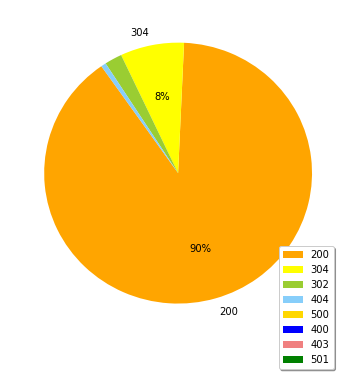

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = responseCodeToCount.map(lambda x: x[0]).collect()
count = logs_df.count()
proportions = responseCodeToCount.map(lambda x: (float(x[1]) / count)).collect()

def pie_pct_format(value):
    # hide percentage label for slices with small percentages
    return '' if value < 6 else '%.0f%%' % value

fig = plt.figure(figsize=(6, 6), facecolor='white', edgecolor='white')
colors = ['orange', 'yellow', 'yellowgreen', 'lightskyblue', 'gold', 'blue', 'lightcoral', 'green']
patches, texts, autotexts = plt.pie(proportions, labels=labels, colors=colors,
                                    autopct=pie_pct_format, shadow=False,  startangle=125)
   
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # hide text label for slices with small percentages
        
plt.legend(labels, loc=(0.80, -0.1), shadow=True)

## Endpoints analysis

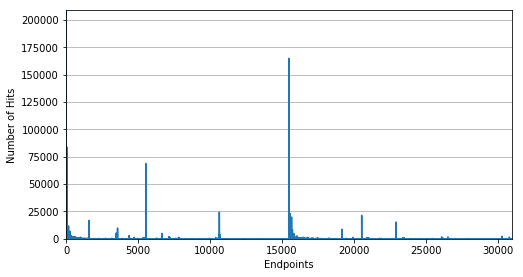

In [22]:
endpoints = (logs_rdd
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda x: x[0]).collect()
counts = endpoints.map(lambda x: x[1]).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)

We now create a new dataframe with two columns: host and day (extracted from time).

### Top ten endpoints

In [23]:
endpointCounts = (logs_rdd
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

In [24]:
print('Top ten endpoints')
sc.parallelize(topEndpoints, 10).toDF().show(truncate=False)

Top ten endpoints
+---------------------------------------+------+
|_1                                     |_2    |
+---------------------------------------+------+
|/images/NASA-logosmall.gif             |208714|
|/images/KSC-logosmall.gif              |164970|
|/images/MOSAIC-logosmall.gif           |127908|
|/images/USA-logosmall.gif              |127074|
|/images/WORLD-logosmall.gif            |125925|
|/images/ksclogo-medium.gif             |121572|
|/ksc.html                              |83909 |
|/images/launch-logo.gif                |76006 |
|/history/apollo/images/apollo-logo1.gif|68896 |
|/shuttle/countdown/                    |64736 |
+---------------------------------------+------+



### Top ten error endpoints

In [25]:
not200 = logs_rdd.filter(lambda log: log.status != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b : a + b)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])

In [26]:
print('Top ten error endpoints')
sc.parallelize(topTenErrURLs, 10).toDF().show(truncate=False)

Top ten error endpoints
+---------------------------------------+-----+
|_1                                     |_2   |
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



## Hosts analysis

### Number of unique hosts

In [27]:
hosts = logs_rdd.map(lambda log: log.host)

uniqueHosts = hosts.distinct()

uniqueHostCount = uniqueHosts.count()
print('Unique hosts: %d' % uniqueHostCount)

Unique hosts: 137933


### Number of unique daily hosts

In [28]:
from pyspark.sql import functions as F
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



In [29]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-----------------------+---+
|host                   |day|
+-----------------------+---+
|129.94.144.152         |1  |
|slip1.yab.com          |1  |
|205.184.190.47         |1  |
|204.120.34.71          |1  |
|ppp3_130.bekkoame.or.jp|1  |
+-----------------------+---+
only showing top 5 rows



In [30]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort('day'))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,7609
1,2,4858
2,3,10238
3,4,9411
4,5,9640
...,...,...
26,27,6846
27,28,6090
28,29,4825
29,30,5265


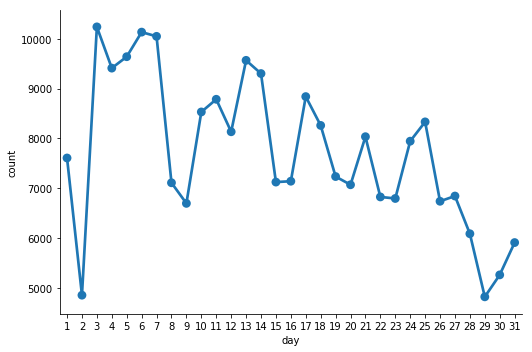

In [31]:
import seaborn as sns
sns.catplot(x='day', y='count', data=daily_hosts_df, kind='point', height=5, aspect=1.5)

### Average number of daily requests per hosts

In [32]:
# df with columns day, total number of hosts
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col('day'), col('count').alias('total_hosts')))

# df with columns day, total number of daily requests
total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth('time').alias('day'))
                              .groupBy('day')
                              .count()
                              .select(col('day'), 
                                      col('count').alias('total_reqs')))

# join the 2 df's
avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')

# add a column: average daily requests per hosts
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
...,...,...,...,...
26,27,94503,6846,13.804119
27,28,82617,6090,13.566010
28,29,67988,4825,14.090777
29,30,80641,5265,15.316429


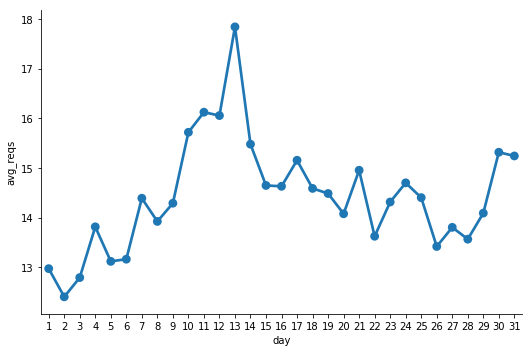

In [33]:
sns.catplot(x='day', y='avg_reqs', data=avg_daily_reqests_per_host_df, kind='point', height=5, aspect=1.5)

## 404 analysis

In [34]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print('Found %s 404 responses' % not_found_df.count())

Found 20899 404 responses


In [35]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

### Top twenty 404 urls

In [36]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|dialip-217.den.mmc.com     |62   |
|www-b4.proxy.aol.com       |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|www-d2.proxy.aol.com       |59   |
|piweba2y.prodigy.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



## Visualizing 404 errors per day

In [37]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
...,...,...
26,27,706
27,28,504
28,29,420
29,30,571


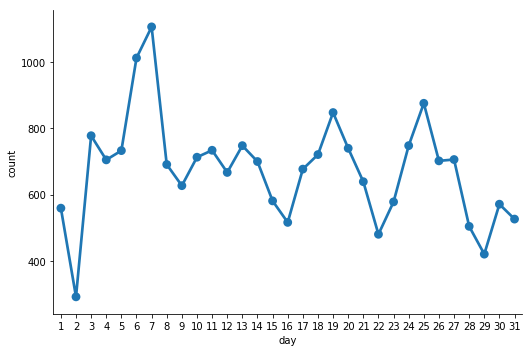

In [38]:
sns.catplot(x='day', y='count', data=errors_by_date_sorted_pd_df, kind='point', height=5, aspect=1.5)

### Top three days for 404 errors

In [39]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows

